<a href="https://colab.research.google.com/github/emrysguo/Quantum-approximate-optimisation-algorithms-for-real-world-scenarios---Strangeworks/blob/main/maxcut_jumpstartV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Strangeworks Hackathon
### Team Jumpstart Quantum

### Challenge Goal

-

-

-

### Python Version

In [1]:
from platform import python_version

print("The current version of python is "+python_version())
if python_version() != '3.9.11':
    print("Please Update Python")

The current version of python is 3.7.13
Please Update Python


### Install Libraries

After running the cell below, you may need to resart the Jupyter notebook for them to take effect. 

In [2]:
!pip install networkx
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.6 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=b0bd0e67ebdf3fa7a3f3ae9556a874f6047bf8b36b2503c77e4577b1747414b6
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.0 MB/s 
     |████████████████████████████████| 18.0 MB 18.6 MB/s 
     |████████████████████████████████| 240 kB 57.3 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████

### Quantum Approximate Optimisation Algorithm (QAOA)

This short tutorial is borrowed heavily from the qiskit webpage - https://qiskit.org/textbook/ch-applications/qaoa.html. 

This implementation, while currently running on your local computer, is written in such a way that we only have to change the "backend" and it will run on IBMs superconducting quantum hardware.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

### Max-Cut problem 

A Max-Cut problem involves partitioning nodes of a graph into two sets, such that the number of edges between the sets is maximum. The example below has a graph with four nodes and some of the ways in which it can be partitioned into two sets, "red" and "blue" is shown.

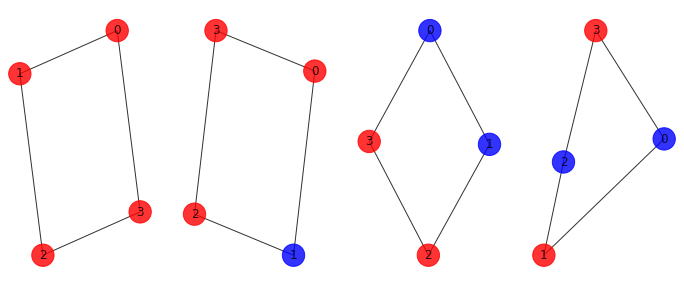

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(12,5))
plt.subplot(1, 4, 1)
color_map = ['red','red','red','red']
nx.draw(G, node_color=color_map, with_labels=True, alpha=0.8, node_size=500)

plt.subplot(1, 4, 2)
color_map = ['red','blue','red','red']
nx.draw(G, node_color=color_map, with_labels=True, alpha=0.8, node_size=500)

plt.subplot(1, 4, 3)
color_map = ['blue','blue','red','red']
nx.draw(G, node_color=color_map, with_labels=True, alpha=0.8, node_size=500)

plt.subplot(1, 4, 4)
color_map = ['blue','red','blue','red']
nx.draw(G, node_color=color_map, with_labels=True, alpha=0.8, node_size=500)

For 4 nodes, as each node can be assigned to either the "red" or "blue" sets, there are $2^4=16$ possible assigments, out of which we have to find one that gives maximum number of edges between the sets "red" and "blue". The number of such edges between two sets in the figure, as we go from left to right, are 0, 2, 2, and 4. We can see, after enumerating all possible $2^4=16$ assignments, that the rightmost figure is the assignment that gives the maximum number of edges between the two sets. Hence if we encode "red" as 0 and "blue" as 1, the bitstrings "0101" and "1010" that represent the assignment of nodes to either set are the solutions.   

As you may have realized, as the number of nodes in the graph increases, the number of possible assignments 
that you have to examine to find the solution increases exponentially. If N is the number of nodes, the number of solutions grows as: $2^N$.

## QAOA

QAOA (Quantum Approximate Optimization Algorithm) introduced by Farhi et al.[1] is a quantum algorithm that attempts to 
solve such combinatorial problems.<br> 

It is a variational algorithm that uses a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters 
$(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$. 
The goal of the algorithm
is to find optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the 
quantum state $\lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ encodes the solution to the problem. 

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries 
$U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$
where $H_B$ is the mixing Hamiltonian and $H_P$ is the problem Hamiltonian (defined below). Such a choice of unitary drives its inspiration 
from a related scheme called quantum annealing.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that 

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle$$

where $\lvert \psi_0 \rangle$ is a suitable initial state. 

We will demonstrate these steps using the Max-Cut problem discussed above. For that we would first define
the underlying graph of the problem.

### First things First, Define the Graph

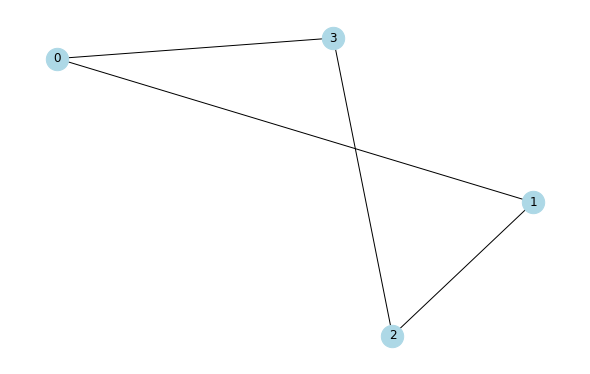

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby

# Number of nodes in the graph. Directly corresponds to the number of qubits
# Be careful and don't make this number too big, your computer may crash. 
# The classical computational cost of simulating this (on classical hardware),
# scales as 2^nodes. There is a reason that we need quantum computers!
nodes = 4

# Energy cost for having node occupied. It is negative so it is favourable for having this occupied.
weights_nodes = [-2,-2,-2,-2,-2,-2]

# Cost for having two connected nodes occupied. This may counteract the positive benefit (weights_nodes)
# for having the nodes occupied, and leads to the complexity for the problem.
weights_edges = [1,2,2,1]

random.seed(1)

G = nx.Graph()
for nn in range(0,nodes):
    G.add_nodes_from([(nn,{'weight': weights_nodes[nn]})])
    

edges = combinations(range(nodes), 2)
iter=0
for _, node_edges in groupby(edges, key=lambda x: x[0]):
    node_edges = list(node_edges)
    random_edge = random.choice(node_edges)
    G.add_edges_from([(random_edge[0], random_edge[1],{'weight': weights_edges[iter]})])
    iter += 1

    for e in node_edges:
        if random.random() < 0.4:
            G.add_edges_from([(e[0], e[1],{'weight': weights_edges[iter]})])
            iter += 1


plt.figure(figsize=(8,5))
nx.draw(G, node_color='lightblue', 
        with_labels=True, 
        node_size=500)


The problem Hamiltonian specific to the Max-Cut problem up to a constant here is:

$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + 
        \frac{2}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) +
        \frac{2}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big) \\
            \\
            \\
        -\big(Z_0 \otimes I_1 \otimes I_2 \otimes I_3\big)  
        -\big(I_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) 
        -\big(I_0 \otimes I_1 \otimes Z_2 \otimes I_3\big)
        -\big(I_0 \otimes I_1 \otimes I_2 \otimes Z_3\big)
$$

To contruct such a Hamiltonian for a problem, one needs to follow a few steps that we'll cover in later sections of this page.

### Exact Solution

In this section we find the exact ground state of the above Hamiltonian by finding the eigenstates with the lowest energy. This only works for a small number of qubits, due to the exponential scaling of the computational complexity, but it is useful for benchmarking the QAOA algorithm that we will describe below. 

In [6]:
import numpy as np
import scipy.sparse.linalg as sla
import copy

edges = np.zeros((len(G.edges()),2),dtype=int)
we = np.zeros(len(G.edges()),dtype=float)
iter = 0
for x in G.edges():
    edges[iter,0] = x[0]
    edges[iter,1] = x[1]
    we[iter] = G.edges[x]["weight"]
    iter = iter + 1

wn = np.zeros(len(G.nodes()),dtype=float)
iter = 0
for i in G.nodes():
    wn[iter] = G.nodes[i]["weight"]
    iter = iter + 1

def TensorProd(A):

    out = np.kron(A[0],A[1])
    for oo in range(2,len(A)):
        out = np.kron(out,A[oo])

    return out

sz = [[1.0,0.0],[0.0,0.0]]

A0 = []
for n in range(0,nodes):
    A0.append(np.eye(2))

out = TensorProd(A0)

Ham = np.zeros((np.power(2,nodes),np.power(2,nodes)),dtype=float)
for p in range(0,nodes):
    A = copy.deepcopy(A0)
    A[p] = sz
    Ham += wn[p] * TensorProd(A)

for p in range(0,len(G.edges())):
    A = copy.deepcopy(A0)
    A[edges[p][0]] = sz
    A[edges[p][1]] = sz
    Ham += we[p] * TensorProd(A)

Egs_exact, V = sla.eigs(Ham, 1, which='SR')

print("The cost of the optimal solution is "+str(np.real(Egs_exact[0])))

The cost of the optimal solution is -4.0


How do you interpret the eigenstate vector V? Does it give you the solution in terms of which nodes are occupied?

### Mixer Hamiltonian and Unitaries

The mixer Hamiltonian $H_B$ is usually of the form:

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + 
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)
$$

As individual terms in the summation of $H_P$ and $H_B$ both commute, we can write the unitaries as:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

Notice that each term in the product above corresponds to an X-rotation on each qubit. And we can write $U(H_P)$ as:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

Let's now examine what the circuits of the two unitaries look like. 

### The Mixing Unitary

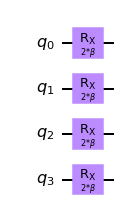

In [7]:
from qiskit import QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw("mpl")

### The Problem Unitary

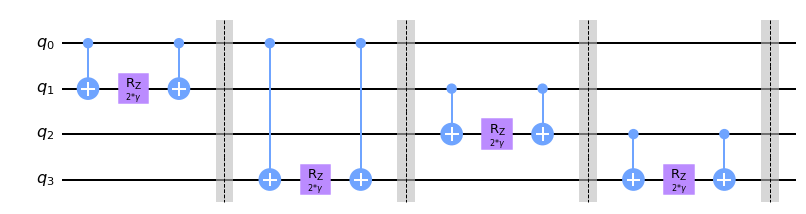

In [8]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw("mpl")

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Such a state, when number of qubits is 4 ($n=4$), can be prepared by applying Hadamard gates starting from an all zero state as shown in 
the circuit below. 

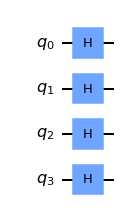

In [9]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw("mpl")

### The QAOA circuit

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements
- Preparing an initial state
- Applying the unitary $U(H_P) = e^{-i \gamma H_P}$ corresponding to the problem Hamiltonian
- Then, applying the mixing unitary $U(H_B) = e^{-i \beta H_B}$

Let's see what it looks like for the example problem:

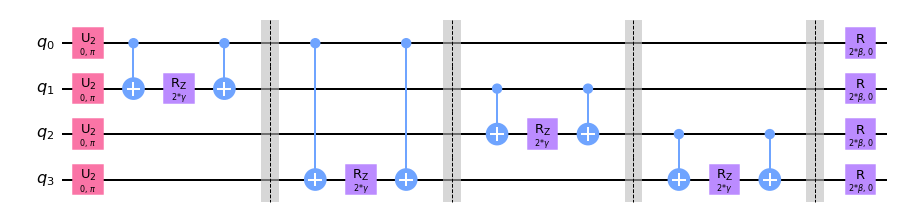

In [10]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw("mpl")

The next step is to find the optimal parameters $(\boldsymbol{\beta_{opt}}, \boldsymbol{\gamma_{opt}})$ such that the expectation value

$$ \langle \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rvert H_P \lvert 
\psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle $$

is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. Following steps are involved as shown in the schematic 

<img src="images/QAOA_schematic.png" width="600" height="200" class="center">

1. Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. Repeat until some suitable convergence criteria is met:
    1. Prepare the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ using qaoa circuit
    2. Measure the state in standard basis
    3. Compute $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ 
    4. Find new set of parameters $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$ using a classical optimization algorithm
    5. Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters 
      $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$

The code below implements the steps mentioned above.

In [11]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
    
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] == x[j] and x[i] == "1":
            obj += G.edges[(i,j)]["weight"]

    for i in G.nodes():
        if x[i] == "1":
            obj += G.nodes[i]["weight"]
            
    return obj
            

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Global variable: measure_fract
                     only top fraction of counts are averaged
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    measured_cuts = []
    
    if (measure_fract == 1.0):
        for bitstring, count in counts.items():
            obj = maxcut_obj(bitstring, G)
            avg += obj * count
            sum_count += count
        return avg/sum_count
    else:
        counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
        n = int(measure_fract*len(counts_sorted))
        counts_fract = dict(list(counts_sorted.items())[0:n])
        for bitstring, count in counts_fract.items():
            obj = maxcut_obj(bitstring, G)
            avg += obj * count
            sum_count += count
        #print("sum_count " + str(sum_count) )
        return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for nod in list(G.nodes()):
            qc.rz(2 * gamma[irep]*G.nodes[nod]["weight"], nod)
            
            
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep]*G.edges[pair]["weight"], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, backend, hardware, shotsin,seed):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)

        # We need this step if we want to run on hardware. 
        # tqc = qiskit.compiler.transpile(qc,backend)
        if (hardware == 1):
            tqc = transpile(qc,backend)
        else:
            tqc = qc

        counts = backend.run(tqc, seed_simulator=seed,shots = shotsin).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

### Part I Standard Qiskit Simulator

Experiments on simulator

Here.
 


In [12]:
from scipy.optimize import minimize
from qiskit import *
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA

backend = Aer.get_backend('qasm_simulator')

# Max number of optimisation iterations
#maxiter = 100
maxiter = 1000

p = 4
theta = []
for i in range(4*p):
    theta.append(1.0)

# Number of quantum measurements each time the quantum circuit is called
shotsin = 200
measure_fract = 0.8

# We have random outcomes for the measurements.
# So for the simulation it is good practice to seed the random number generator
seed = 2

expectation = get_expectation(G, backend, 0, shotsin,seed)

options = {'maxiter': maxiter}
res = minimize(expectation,theta,options=options,method='COBYLA')

res

     fun: -3.909090909090909
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 153
  status: 1
 success: True
       x: array([1.01821187, 0.7602872 , 2.05955982, 1.91290671, 1.00178882,
       0.86037854, 1.22767027, 1.09367012, 0.85781646, 1.01432353,
       1.00912554, 1.04364428, 1.05249002, 0.95934187, 0.99886092,
       0.9351464 ])

### Analyzing the result

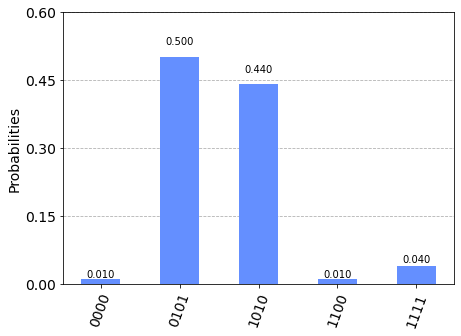

In [13]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=seed,shots = shotsin).result().get_counts()

plot_histogram(counts)

### Questions to think about

- There is clearly a distribution of solutions present in the output of the quantum circuit. This is quantum superposition at work. However, this is an artifact of the quantum problem, and a classical solution would be only one of these basis states. How would we sensbily map this to the solution for the classical problem?

- How does the energy of this quantum state, "res.fun", compare to the energy of our exact solution from above, "Egs_exact". How does it compare to the energy of each of the basis states?

- What metrics should we come up with to analyse/interpret the quality of our solution?

### Cost

In [14]:
task_price = 0.25 # price for submitting task to system (in dollars)

price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars)
price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars)
price_per_Xrot = 0.00008 # price for a single X rotation (in dollars)

price_per_shot = p * (len(G.edges()) * (2* price_per_CNOT + price_per_Zrot) + len(G.nodes()) * price_per_Xrot)

Optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called.
Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware.

Cost = (Optim_evals * shotsin * price_per_shot) + task_price

print("The estimated cost is = $"+str(Cost))

The estimated cost is = $152.026


### Part II Qiskit Noisy Simulator

Experiments on noisy simulator

Here.

In [15]:
from scipy.optimize import minimize
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.fake_provider import FakeManilaV2

# Get a fake backend from the fake provider
backend = FakeManilaV2()

# Max number of optimisation iterations
#maxiter = 100
maxiter = 1000

p = 4
theta = []
for i in range(4*p):
    theta.append(1.0)


# Number of quantum measurements each time the quantum circuit is called
shotsin = 200
measure_fract = 0.2

# We have random outcomes for the measurements.
# So for the simulation it is good practice to seed the random number generator
seed = 2

expectation = get_expectation(G, backend, 1, shotsin,seed)

options = {'maxiter': maxiter}
res = minimize(expectation,theta,options=options,method='COBYLA')

res

     fun: -3.413793103448276
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 148
  status: 1
 success: True
       x: array([2.00084189, 0.99172454, 0.99754858, 1.0134109 , 1.01396581,
       0.9988117 , 1.99214021, 1.00581438, 1.02438848, 0.98271141,
       0.99633608, 1.00015329, 1.00395868, 0.99690891, 1.00036362,
       0.99584499])

### Analyzing the result

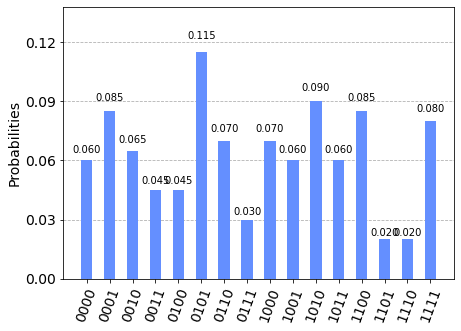

In [16]:
from qiskit.visualization import plot_histogram

backend = FakeManilaV2()

qc_res = create_qaoa_circ(G, res.x)
tqc_res = transpile(qc_res,backend)

counts = backend.run(tqc_res, seed_simulator=seed,shots = shotsin).result().get_counts()

plot_histogram(counts)

### Cost

In [17]:
task_price = 0.25 # price for submitting task to system (in dollars)

price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars)
price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars)
price_per_Xrot = 0.00008 # price for a single X rotation (in dollars)

price_per_shot = p * (len(G.edges()) * (2* price_per_CNOT + price_per_Zrot) + len(G.nodes()) * price_per_Xrot)

Optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called.
Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware.

Cost = (Optim_evals * shotsin * price_per_shot) + task_price

print("The estimated cost is = $"+str(Cost))

The estimated cost is = $147.066


## References<a id="references"></a>
1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)